In [862]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [385]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline
img_test = cv2.cvtColor(cv2.imread("Images/test_images/straight_lines1.jpg"), cv2.COLOR_BGR2RGB)
img_size = (img_test.shape[1], img_test.shape[0])
# Undistortion Function, we just load the distortion co-efficients and undistort the image
def undistort(img):
    with open("C:/Users/lenovo/Documents/SDCND/Advanced-Lane-Finding/dist_pickle.p", "rb") as fname:
        dp = pickle.load(fname)
        mtx = dp["Camera_Matrix"] 
        dist = dp["Distortion_Coefficients"]
        dst = cv2.undistort(img, mtx, dist, None ,mtx)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
        ax1.set_title("Original Image")
        ax1.imshow(img, cmap = "gray")
        ax2.set_title("Undistorted Image")
        ax2.imshow(dst, cmap = "gray")
        return dst
# An example
#dst = undistort(img_test)

In [966]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline
# HERE WE DEFINE THE FUNCTIONS FOR THRESHOLDING in X Gradient, Magnitude Gradient, Direction, and Color Thresholding.
# Read in an image and grayscale it
# This function will provide a binary image thresholded based on x or y gradient values
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == "x":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobel = np.abs(sobel)
    sobel_scaled = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(sobel_scaled)
    grad_binary[(sobel_scaled >= thresh[0]) & (sobel_scaled <= thresh[1])] = 1
    #plt.title("Sobel X Binary with Thresholds: {:.1f}, {:.1f}".format(thresh[0], thresh[1]))
    #plt.imshow(grad_binary, cmap = "gray"), plt.show()
    return grad_binary
# This function will return a binary image thresholded based on magnitude of the gradient
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    sobel_scaled = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    mag_binary = np.zeros_like(sobel_scaled)
    mag_binary[(sobel_scaled >= mag_thresh[0]) & (sobel_scaled <= mag_thresh[1])] = 1
    #plt.title("Magnitude Thresholding"),plt.imshow(mag_binary, cmap = "gray"), plt.show()
    return mag_binary
# This function will return a binary image thresholded based on orientation of gradient
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    orient = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(orient)
    dir_binary[(orient >= thresh[0]) & (orient <= thresh[1])] = 1
    #plt.title("Dir binary"), plt.imshow(dir_binary, cmap = "gray"), plt.show()
    return dir_binary
# This function returns a binary image thresholded based on white HSV value range
def white_threshold_HSV(img, lower = [0, 0, 200], upper = [255, 30, 255]):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    figures = {}
    labels = {}
    names = ["H", "S", "V"]
    for i in range(3):
        figures[i] = img_hsv[:, :, i]
        labels[i] = names[i]
    lower_white = np.array(lower, dtype = np.uint8)
    upper_white = np.array(upper, dtype = np.uint8)
    white_thresh = cv2.inRange(img_hsv, lower_white, upper_white)
    figures[3] = white_thresh
    labels[3] = "Thresh"
    #plot_thresholded(figures, 1, 4, labels)
    return white_thresh


def yellow_threshold_HLS(img, lower = [0, 0, 140], upper = [40, 255, 255]): #160 or 140?
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    lower_yellow = np.array(lower, dtype = np.uint8)
    upper_yellow = np.array(upper, dtype = np.uint8)
    yellow_thresh = cv2.inRange(img_hls, lower_yellow, upper_yellow)
    #plt.title("Yellow thresholding in HLS")
    #plt.imshow(yellow_thresh, cmap = "gray"), plt.show()
    return yellow_thresh


# Edit this function to create your own pipeline.
def threshold_pipeline(img, sx_thresh):
    sobelx_binary = abs_sobel_thresh(img, orient = "x", sobel_kernel = 15, thresh = (sx_thresh))
    sobely_binary = abs_sobel_thresh(img, orient = "y", sobel_kernel = 15, thresh = (60, 255))
    white_binary = white_threshold_HSV(img)
    yellow_binary_HLS = yellow_threshold_HLS(img)
    mag_binary = mag_thresh(img, sobel_kernel = 3, mag_thresh = (40, 255))
    dir_binary = dir_threshold(img, sobel_kernel = 3, thresh = (0.65, 1.05) )
    combined = np.zeros_like(yellow_binary_HLS)
    combined[(white_binary == 255) | ((yellow_binary_HLS == 255)) | ((sobelx_binary == 1) & (sobely_binary==1))  | ((mag_binary==1) & (dir_binary == 1))] = 255
    
    left_bottom = (145, img.shape[0])
    apex1 = (550, 455)
    apex2 = (725, 455)
    right_bottom = (1170, img.shape[0])
    vertices = np.array([[left_bottom, apex1, apex2, \
                          right_bottom]], dtype=np.int32)
    
    combined = region_of_interest(combined, vertices)
    return combined
    



In [920]:
# Perspective Transform
def warp(dst, draw_lines = False):
    #source_pts = np.array([ [150, dst.shape[0]], [580, 460], [710, 460], [1150, dst.shape[0]] ], np.float32)
    #source_pts = np.array([ [195, dst.shape[0]], [597, 448], [690, 448], [1190, dst.shape[0]] ], np.float32)
    source_pts = np.array([ [175, dst.shape[0]], [590, 450], [700, 450], [1170, dst.shape[0]] ], np.float32)
    offset = 300
    dst_pts = np.array([ [0 + offset, dst.shape[0]], [0 + offset, 0], [dst.shape[1] - offset, 0], [dst.shape[1] - offset, dst.shape[0]] ], np.float32)
    if draw_lines == True:
        #cv2.line(dst, (150, dst.shape[0]), (150+430, 460), (255, 0, 0), 1)
        #cv2.line(dst, (1150-440, 460), (1150, dst.shape[0]), (255, 0, 0), 1)
        cv2.line(dst, (175, dst.shape[0]), (590, 450), (255, 0, 0), 1)
        cv2.line(dst, (700, 450), (1170, dst.shape[0]), (255, 0, 0), 1)
    M = cv2.getPerspectiveTransform(source_pts, dst_pts)
    Minv = cv2.getPerspectiveTransform(dst_pts, source_pts)
    warped_dst = cv2.warpPerspective(dst, M, (dst.shape[1], dst.shape[0]), flags = cv2.INTER_LINEAR)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
    ax1.set_title("Undistorted + Thresholded Image")
    ax1.imshow(dst, cmap = "gray")
    ax2.set_title("Undistorted + Thresholded + Warped Image")
    ax2.imshow(warped_dst, cmap = "gray")
    return warped_dst, M, Minv
#a = warp(dst)

In [921]:
def final_pipeline(image):
    undistorted_image = undistort(image)
    thresholded_image = threshold_pipeline(undistorted_image, sx_thresh = (10, 255))
    warped_image, M, Minv = warp(thresholded_image, draw_lines = False)
    binary_warped = cv2.threshold(warped_image, 50, 255, cv2.THRESH_BINARY)[1]
    return binary_warped

In [951]:
# warped = binary_warped
# histogram = np.sum(warped[warped.shape[0] // 2:, :], axis = 0)/255
# print(histogram)
# plt.imshow(warped, cmap = "gray")
# plt.plot(histogram), plt.show()

C:/Users/lenovo/Documents/SDCND/Advanced-Lane-Finding/Images/test_images\test1.jpg
(720, 1280)
0


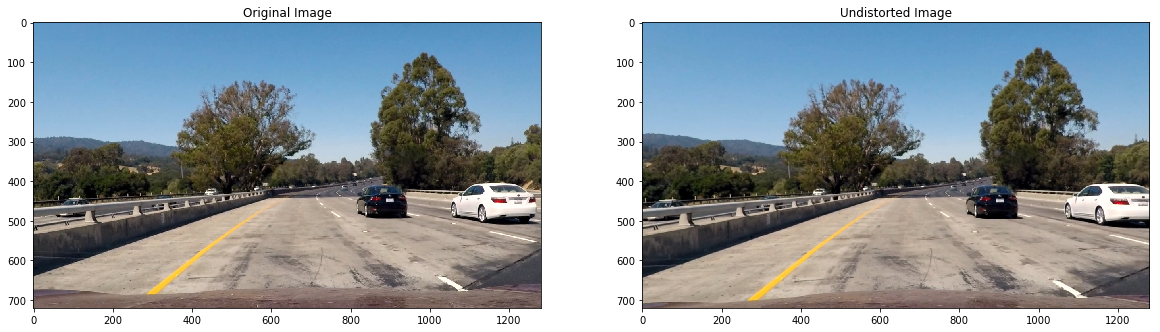

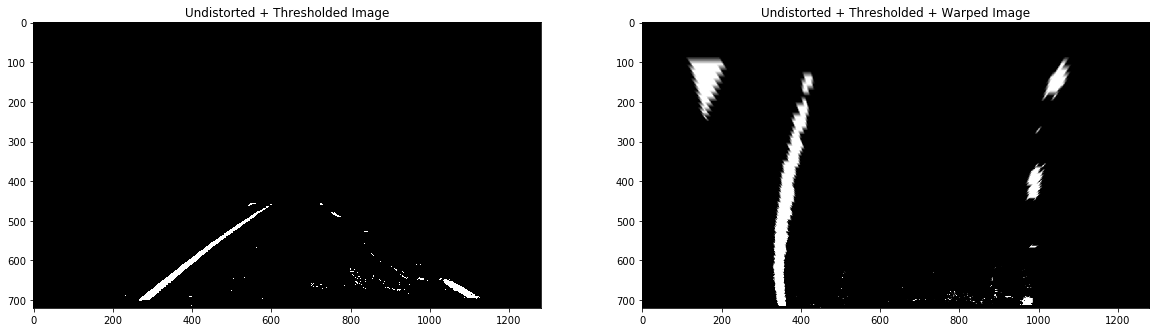

In [967]:
# Test undistortion and warping on thresholded images
import matplotlib.image as mpimg
import time
import glob

imagepaths = glob.glob("C:/Users/lenovo/Documents/SDCND/Advanced-Lane-Finding/Images/test_images/*.jpg")
imstack = np.zeros( (720, 1280, len(imagepaths)))
for k, fname in enumerate(imagepaths[4:]):
    print(fname)
    image = mpimg.imread(fname)
    binary_warped = final_pipeline(image)
    print(binary_warped.shape)
    print(k)
    imstack[:, :, k-1] = binary_warped
    
    break
warped = binary_warped    

In [968]:
# Calculating the radius of curvature
def radius_of_curvature(left_fitx, right_fitx):
    
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    #print(left_fitx)
    #print(right_fitx)
    left_fitcr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fitcr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    y_eval = np.max(ploty)
    print(y_eval)
    print(left_fitcr)
    print(right_fitcr)
    left_curve_rad = ((1 + (2*left_fitcr[0]*y_eval*ym_per_pix + left_fitcr[1])**2)**1.5) / np.absolute(2*left_fitcr[0])
    right_curve_rad = ((1 + (2*right_fitcr[0]*y_eval*ym_per_pix + right_fitcr[1])**2)**1.5) / np.absolute(2*right_fitcr[0])
    print("The radius of curvature is:", left_curve_rad, "m", right_curve_rad, "m")


719.0
[  7.31085336e-04  -4.31249114e-02   2.46095002e+00]
[  6.39841924e-04  -4.32851291e-02   5.76896228e+00]
The radius of curvature is: 683.915161881 m 781.471708522 m


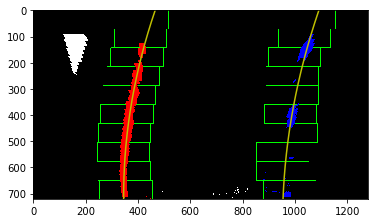

In [969]:
def find_lane_lines_new_fit(binary_warped, nWindows = 10, margin = 100, plot = True):
        # First define an output image, on which we can visualize the windows and lanes
        output_image = np.dstack((binary_warped, binary_warped, binary_warped)) # 3 channel image
        # Next we have to define the midpoint for each lane.
        histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis = 0)/255
        midpoint = np.int(binary_warped.shape[1] / 2)
        leftx_mid = np.argmax(histogram[:midpoint])
        rightx_mid = np.argmax(histogram[midpoint:]) + midpoint     
        window_height = np.int(binary_warped.shape[0] / nWindows)

        # Let us get all x and y co-ordinates of non zero pixels
        non_zero = binary_warped.nonzero()
        non_zeroy = np.array(non_zero[0])
        non_zerox = np.array(non_zero[1])
    
        # Current positions of windows, these will be updated once we find a windows with a min number of pixels
        leftx_current = leftx_mid
        rightx_current = rightx_mid
        min_pixel = 50 # this can be adjusted

        # Empty lists to store the left and right lanes indices
        left_lane_inds = []
        right_lane_inds = []
        lane_width = []
        lane_width.append(rightx_mid - leftx_mid)

        for window in range(nWindows):
            # Define window boundaries
            window_ylow = binary_warped.shape[0] - (window + 1)*(window_height)
            window_yhigh = binary_warped.shape[0] - (window)*(window_height)
            window_xleft_low = leftx_current - margin    
            window_xleft_high = leftx_current + margin
            window_xright_low = rightx_current - margin
            window_xright_high = rightx_current + margin
            # Draw the windows on the output image
            cv2.rectangle(output_image,(window_xleft_low,window_ylow),(window_xleft_high,window_yhigh),
            (0,255,0), 2) 
            cv2.rectangle(output_image,(window_xright_low,window_ylow),(window_xright_high,window_yhigh),
            (0,255,0), 2) 
            # Find the left and right non zero indices which are in each of the windows
            good_left_inds = ((non_zeroy >= window_ylow) & (non_zeroy < window_yhigh) & 
                             (non_zerox >= window_xleft_low) &  (non_zerox < window_xleft_high)).nonzero()[0]
    
            good_right_inds = ((non_zeroy >= window_ylow) & (non_zeroy < window_yhigh) &
                              (non_zerox >= window_xright_low) & (non_zerox < window_xright_high)).nonzero()[0]
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If the window has enough pixels, update the x position of the lane
            if len(good_left_inds) > min_pixel:        
                leftx_current = np.int(np.mean(non_zerox[good_left_inds]))
            if len(good_right_inds) > min_pixel:
                rightx_current = np.int(np.mean(non_zerox[good_right_inds]))
            lane_width.append(rightx_current - leftx_current)
        
        avg_lane_width = np.mean(lane_width)
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        # Extract the pixel positions for each lane and store them in the line objects
        leftx = non_zerox[left_lane_inds]
        lefty = non_zeroy[left_lane_inds]
        
        
        rightx = non_zerox[right_lane_inds]
        righty = non_zeroy[right_lane_inds]
        
        
        # We are fitting a polynomial for each lane. We will use these co-efficients to predict an x co-ordinate
        # for a given y co-ordinate. Hence the order of inputs to np.polyfit, first y co-ordinates and then x.
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        #self.left_lane.current_fit = left_fit
        #self.right_lane.current_fit = right_fit
        
        # Now let us color all the non zero pixels which belong to left and right lane lines in the output image
        output_image[non_zeroy[left_lane_inds], non_zerox[left_lane_inds]] = (255, 0, 0)
        output_image[non_zeroy[right_lane_inds], non_zerox[right_lane_inds]] = (0, 0, 255)
        # For every y co-ordinate in the image, predict an x co-ordinate for each lane using the fit
        ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])  # All the y co-ordinates  
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2] # Predicted x co-ordinates for left lane
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] # Predicted x co-ordinates for right lane
        
        # Now we have the got the x values from the fit, lets insert them in the first position of the list
        #self.left_lane.recent_xfitted.insert(0, left_fitx)        
        #self.right_lane.recent_xfitted.insert(0, right_fitx)
        
        
        
        # For radius of curvature calculations, lets find left_fitcr and right_fitcr
#         ym_per_pix = 30/720
#         xm_per_pix = 3.7/(rightx_mid - leftx_mid)
#         left_fitcr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
#         right_fitcr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
#         left_curve_rad = ((1 + (2*left_fitcr[0]*y_eval*ym_per_pix + left_fitcr[1])**2)**1.5) / np.absolute(2*left_fit[0])
#         right_curve_rad = ((1 + (2*right_fitcr[0]*y_eval*ym_per_pix + right_fitcr[1])**2)**1.5) / np.absolute(2*right_fitcr[0])
        #self.left_lane.radius_of_curvature = left_curve_rad
        #self.right_lane.radius_of_curvature = right_curve_rad
        
        # Vehicle offset
#         lane_center_meters = ((leftx_mid + rightx_mid) // 2)*xm_per_pix
#         pixels_between_lanes = (leftx_mid - rightx_mid) # This will be used for sanity check
#         image_center_meters = ((binary_warped.shape[1] // 2))*xm_per_pix
#         line_base_pos = lane_center_meters - image_center_meters
#         print("The vehicle is off by {:.3f} meters".format(self.line_base_pos))
        
        
        if plot == True:
            plt.imshow(output_image)
            plt.plot(left_fitx, ploty, "y")
            plt.plot(right_fitx, ploty, "y")
            plt.xlim([0, 1280])
            plt.ylim([720, 0])
        
        return left_fit, right_fit, left_fitx, right_fitx, avg_lane_width
left_fit, right_fit, left_fitx, right_fitx, avg_lane_width = find_lane_lines_new_fit(warped)
radius_of_curvature(left_fitx, right_fitx)

In [970]:
print(len(imstack))

720


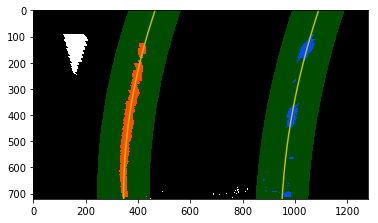

In [971]:
# We can now use the results of this fit, to predict which pixels will be lane lines in the next frame.
# assume we receive a new warped image

# 1. Read in a new image (jpg format) using mpimg. And send it through the pipeline (undistort, threshold, warp). Get an output
# binary warped image.
# 2. Now assuming this is the very first image, send it through the finding lane lines function. Which will return a fit for
# the right lane line and left lane line. As well as any other information , such as left lane indices and right lane indices.
# 3. Now create another function which takes as input, a binary warped image and left fit and right fit coefficients.
# 4. Finally take all these functions and properties and create a class called Lines().
def find_lane_lines_previous_fit(binary_warped, left_fit, right_fit, visualize = True):
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        predxleft = (left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2])
        predxright = (right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2])
        left_lane_inds = ((nonzerox > predxleft - margin) & (nonzerox < predxleft + margin))
        right_lane_inds = ((nonzerox > predxright - margin) & (nonzerox< predxright + margin))
    
        # Get the new lane pixel positions
        lefty = nonzeroy[left_lane_inds]
        leftx = nonzerox[left_lane_inds]
        righty = nonzeroy[right_lane_inds]
        rightx = nonzerox[right_lane_inds]
    
        # Now we can find a new fit
        left_fit_new = np.polyfit(lefty, leftx, 2)
        right_fit_new = np.polyfit(righty, rightx, 2)
    
        # Let us plot it like how we did before
        ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
        left_fitx = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
        right_fitx = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]
        
        
    
        # For future radius of curvature calculations, lets find left_fitcr and right_fitcr
#         ym_per_pix = 30/720
#         xm_per_pix = 3.7/600
#         left_fitcr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
#         right_fitcr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
        # Visualize window, lane pixels and polynomial fit line on an output image
        if visualize == True:
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))
            window_img = np.zeros_like(out_img)
            # Color the left and right lane pixels
            out_img[lefty, leftx] = (255, 0, 0)
            out_img[righty, rightx] = (0, 0, 255)
            # Define the left and right lines of the window, and create points which we can use in cv2.fillPoly
            window_leftline1= np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
            # For the line2 of left lane, we need to flip the array upside down, so as to continue from the bottom to top in order!
            window_leftline2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
            left_line_pts = np.hstack((window_leftline1, window_leftline2))
            window_rightline1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
            # similarly for line 2 of right lane
            window_rightline2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
            right_line_pts = np.hstack((window_rightline1, window_rightline2))
            cv2.fillPoly(window_img, np.int_(left_line_pts), (0, 255, 0))
            cv2.fillPoly(window_img, np.int_(right_line_pts), (0, 255, 0))
            result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
            plt.imshow(result)
            plt.plot(left_fitx, ploty, 'y')
            plt.plot(right_fitx, ploty, 'y')
            plt.xlim([0, 1280]), plt.ylim([720, 0])
        
        return left_fit, right_fit, left_fitx, right_fitx
left_fit, right_fit, left_fitx, right_fitx = find_lane_lines_previous_fit(warped, left_fit, right_fit) 
# My attempt at using cv2.fillPoly
# Left lane, get the 4 corner points.

